# Modelling

After cleaning and preprocessing the data, we model the data distributions by trying to fit it into some well known models. We execute the following steps to do a fair modelling : 

1. Splitting the Data into Training and Test Sets

2. Hyperparameter Tuning : Models, hyperparameters and loss function

3. Evaluation of Models on the Test Data

4. Retraining the Best Model on the complete training set for prediction.

5. Interpretation of Results

# 0. Import Libraries & Data

In [6]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv("../data/preprocessed_airbnb_data.csv")
df.head()

,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,attr_index_norm,rest_index_norm,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,city_amsterdam,city_athens,city_barcelona,city_berlin,city_budapest,city_lisbon,city_london,city_paris,city_rome,city_vienna,day_type_weekdays,day_type_weekends,space_index,metro_to_city_dist_ratio,price
0,0,1,0,1.000,0.575995,-0.661727,-0.441734,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.563830,1.043721,-0.253920
1,0,0,0,0.750,0.290887,1.989541,1.685065,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.032003,1.011956,0.707075
2,0,0,1,0.875,0.347063,-0.678112,-0.449985,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.563830,1.278779,0.262849
3,0,0,1,0.875,0.448981,1.327768,1.793710,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.031651,1.883336,1.093609
4,1,0,0,1.000,0.857603,1.613574,1.621825,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.563830,1.194023,1.283568


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   host_is_superhost           51707 non-null  int64  
 1   multi                       51707 non-null  int64  
 2   biz                         51707 non-null  int64  
 3   cleanliness_rating          51707 non-null  float64
 4   guest_satisfaction_overall  51707 non-null  float64
 5   attr_index_norm             51707 non-null  float64
 6   rest_index_norm             51707 non-null  float64
 7   room_type_Entire home/apt   51707 non-null  float64
 8   room_type_Private room      51707 non-null  float64
 9   room_type_Shared room       51707 non-null  float64
 10  city_amsterdam              51707 non-null  float64
 11  city_athens                 51707 non-null  float64
 12  city_barcelona              51707 non-null  float64
 13  city_berlin                 517

# 1. Splitting the Data into Train and Test Sets.

It is good practice to split the data into training, validation and test sets. Validation set is useful for hyperparameter tuning and model selection. Therefore, during hyperparameter tuning, we apply K fold cross validation. It is important to keep the test set completely independent to make sure that the model does not overfit and that there is no data leakage between the train and test set.

80:20 split for training and test set is an accepted split to use, since it provides enough data for cross validation based hyperparameter tuning and test set, as we have a large amount of data (50,000 + data samples).

In [10]:
X = df.drop('price', axis=1)
y = df['price']

# splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (41365, 24)
Testing set shape: (10342, 24)


# 2. Creating Pipelines & Hyperparameter tuning

## A. Models and hyperparameters

## Linear Models

### 1. Linear Regression

- `fit_intercept` :  whether to calculate the intercept for the model.
- `normalize` :  X will be normalized before regression.

### 2. Ridge Regression 

- `alpha` : Constant that multiplies the L2 term, controlling regularization strength
- `fit_intercept` :  whether to calculate the intercept for the model.

### 3. Lasso Regression

- `alpha` : Constant that multiplies the L1 term, controlling regularization strength.
- `fit_intercept` :  whether to calculate the intercept for the model.

### 4. Polynomial Regression

- `poly_features__degree` : Choose polynomial degree
- `fit_intercept` :  whether to calculate the intercept for the model.

## Tree Models (Non - Linear Models)

### 5. Random Forest Regression

A random forest is a meta estimator that fits a number of decision tree regressors on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

- `n_estimators`: Number of trees in the forest. Common values are around 100-300, but this can be tuned.
- `max_depth`: Maximum depth of the trees. None means nodes are expanded until all leaves are pure or until they contain fewer than min_samples_split samples.
- `min_samples_split`: Minimum number of samples required to split an internal node. Increasing this value can make the model more robust by reducing overfitting.
- `min_samples_leaf`: Minimum number of samples required to be at a leaf node. A similar effect to min_samples_split.
- `max_features`: Number of features to consider when looking for the best split. Common values include 'auto' (all features), 'sqrt' (square root of the number of features), and 'log2' (logarithm base 2 of the number of features).

### 6. Decision Tree Regression

- `max_depth` : maximum depth of the tree
- `min_samples_split` : minimum number of samples required to split an internal node
- `min_samples_leaf` : minimum number of samples required to be at a leaf node.

### 7. Gradient Boosting Regression

- `n_estimators` : The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
- `learning_rate` : Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
- `max_depth` : Maximum depth of the individual regression estimators.
- `min_samples_split` : minimum number of samples required to split an internal node
- `min_samples_leaf` : minimum number of samples required to be at a leaf node

### 8. XGBoost

- `n_estimators`: Number of trees.
- `learning_rate`: Step size shrinkage used to prevent overfitting.
- `max_depth`: Maximum depth of a tree.
- `min_child_weight`: Minimum sum of instance weight needed in a child.
- `subsample`: Subsample ratio of the training instance.
- `colsample_bytree`: Subsample ratio of columns when constructing each tree.

## Support Vector Machine

### 9. Support Vector Regression
- `kernel` : Specifies the kernel type to be used in the algorithm (‘linear’, ‘poly’, ‘rbf’ etc)
- `C` : Regularization parameter. The strength of the regularization is inversely proportional to C. Penalty is a squared l2.
- `gamma` : Kernel coefficient


In [11]:
# Define pipelines for each model
models = {
    'linear_regression': LinearRegression(),
    'ridge_regression': Ridge(),
    'lasso_regression': Lasso(),
    'polynomial_regression': Pipeline([
        ('poly_features', PolynomialFeatures()),
        ('linear_regression', LinearRegression())]),
    'random_forest': RandomForestRegressor(random_state=42),
    'decision_tree': DecisionTreeRegressor(random_state=42),
    'gradient_boosting': GradientBoostingRegressor(random_state=42),
    'xgboost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'support_vector_regression': SVR(),
}

In [15]:
# Define parameter grids for hyperparameter tuning
param_grid = {
    'linear_regression': {'model__fit_intercept': [True, False]},
    'ridge_regression': {'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'model__fit_intercept': [True, False]},
    'lasso_regression': {'model__alpha' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'model__fit_intercept': [True, False]},
    'polynomial_regression': {'model__poly_features__degree': [2, 3]},
    'random_forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'model__min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
        'model__max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
    },
    'decision_tree' : {'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]},
    'gradient_boosting': {
        'model__n_estimators': [50, 100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    },
    'xgboost': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_child_weight': [1, 3, 5],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0],
    }
    #'support_vector_regression': {
       # 'model__C': [0.1, 1.0, 10.0], 
        #'model__kernel': ['linear', 'rbf'], 
        #'model__gamma': ['scale', 'auto'],
        #'model__epsilon': [0.1, 0.2, 0.5]},
}

**Note : gradient boosting (even through RandomizedSearchCV) is taking a long time to execute, and have therefore not been used.**

In [13]:
# List of models to include in the pipeline
selected_models = ['linear_regression', 'ridge_regression', 'lasso_regression', 
                   'polynomial_regression', 'random_forest', 'decision_tree', 'xgboost']
# 'gradient_boosting', 'support_vector_regression'


# Filter the models dictionary to only include the selected models
filtered_models = {model_name: models[model_name] for model_name in selected_models}

## B. Hyperparameter Tuning and Pipelining

**Hyperparameter Tuning** is important to find the optimal hyperparameters to make the model perform well on the training set. To reduce the chances of overfitting, the different hyperparameter values are performed on a K Fold cross validation set to provide a robust model. `Grid Search CV` allows providing traditionally accepted values for different hyperparameters and find an optimal combination from within them.

**Pipelining**: To execute multiple combinations of hyperparameters for many models, it is important to set up clean model pipelines. This is done through sklearn's `pipeline` module. GridSearchCV along with pipeline utilizes CPU cores in parallel to execute the code faster.

**Loss Function**: It measures how well the model's predictions match the actual target values and guides the optimization process by providing a quantitative measure of the model's performance.

There are many loss functions which can be used. However, it is best to choose a function that aligns with the objective of the task i.e. housing price prediction, along with understanding of the data and the final interpretability. From EDA, we know that there may be some outliers present in the data, even after applying log transformations.

Mean Absolute Error (MAE) treats all errors equally, regardless of magnitude; it is robust to outliers and provides a better interpretable measure of error compared to Mean Squared Error (MSE) - as it is in the same unit as the airbnb price. MSE is more appropriate if the model is required to penalize larger errors heavily; or that there are no outliers (since MSE is sensitive to outliers).

Note : `GridSearchCV` aims to maximize the scoring metrics. Therefore, to minimize the MAE, we should try to maximize the negative MAE, which is done in the scoring parameter of Grid Search.

In [14]:
results = []
# Initialize the GridSearchCV results dictionary
grid_search_results = {}

# Create and evaluate pipelines for each model
for model_name, model in filtered_models.items():
    start_time = time.time()
    pipeline = Pipeline([
        ('model', model)
    ])

    # Set up the appropriate search method
    if model_name == 'support_vector_regression':
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grid[model_name],  # parameter distribution for RandomizedSearchCV
            n_iter=50,  # Number of parameter settings that are sampled
            cv=5,  # 5-fold cross-validation
            scoring='neg_mean_absolute_error',  # Using negative mean absolute error as scoring
            n_jobs=-1,  # Uses all available CPU cores for parallel processing.
            random_state=42  # Ensuring reproducibility
        )
    else:
        search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid[model_name],  # parameter grid for GridSearchCV
            cv=5,  # 5-fold cross-validation
            scoring='neg_mean_absolute_error',  # Using negative mean absolute error as scoring
            n_jobs=-1  # Uses all available CPU cores for parallel processing.
        )

    # Fit the search
    search.fit(X_train, y_train)

    # Store the results
    grid_search_results[model_name] = search
    end_time = time.time()  # End timing
    duration = end_time - start_time  # Calculate duration
    print(f"Time taken to fit {model_name}: {duration} seconds")
    
    results.append({
        'Model': model_name,
        'Best Parameters': search.best_params_,
        'Best CV Score': search.best_score_,
        'Mean Absolute Error': mean_absolute_error(y_test, search.best_estimator_.predict(X_test)),
        'R^2 Score': r2_score(y_test, search.best_estimator_.predict(X_test)),
        'Time Taken (seconds)': duration
    })


Time taken to fit linear_regression: 1.7090260982513428 seconds
Time taken to fit ridge_regression: 0.6611101627349854 seconds
Time taken to fit lasso_regression: 0.6322801113128662 seconds
Time taken to fit polynomial_regression: 960.639110326767 seconds
Time taken to fit random_forest: 526.0203759670258 seconds
Time taken to fit decision_tree: 9.411457777023315 seconds
Time taken to fit xgboost: 351.12487387657166 seconds


# 3. Evaluating Models on the Test Set

For each model, `grid_search` is executed, which stores the following information: 

- `grid_search.best_params_`: a dictionary containing the hyperparameters that resulted in the best performance according to the specified scoring metric i.e. MAE.

- `grid_search.best_score_ `: This attribute gives the best score achieved by the model using the best hyperparameters found during the grid search.

- `grid_search.best_estimator_`: provides the actual model (estimator) instance that was trained with the best hyperparameters.

The performance of the models are measured using the test dataset. The `R2 Score` metric is also calculated.

In [16]:
# Results of the best performances of each model on training set.
results_df = pd.DataFrame(results)
results_df.head()
results_df.to_csv("../data/results.csv", index=False)

Best Model will be the one with the lowest Mean Absolute Error. R2 scores can be used for comparison as well.

In [17]:
best_model = None
highest_r2 = float('-inf')

for result in results:
    if result['R^2 Score'] > highest_r2:
        highest_r2 = result['R^2 Score']
        best_model = result

# Print the best model details
print("Best Model based on R^2 Score:")
print(f"Model: {best_model['Model']}")
print(f"Best Parameters: {best_model['Best Parameters']}")
print(f"Best CV Score: {best_model['Best CV Score']}")
print(f"Mean Absolute Error: {best_model['Mean Absolute Error']}")
print(f"R^2 Score: {best_model['R^2 Score']}")
print(f"Time Taken (seconds): {best_model['Time Taken (seconds)']}")

Best Model based on R^2 Score:
Model: xgboost
Best Parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__min_child_weight': 1, 'model__n_estimators': 300, 'model__subsample': 1.0}
Best CV Score: -0.3422080580463976
Mean Absolute Error: 0.3311586230439916
R^2 Score: 0.7981379777127858
Time Taken (seconds): 351.12487387657166


# 4. Retraining the best model again

Once the best model with its optimal hyperparameters using cross-validation on a training set are identified, it's beneficial (and a best practice) to train the model on all available training data to potentially improve its performance - thereby improving generalization. This is usually possible, when the retraining is not computationally expensive.

In [18]:
best_model_name = best_model['Model']

# Retrieve the best pipeline for the best model
best_model_pipeline = grid_search_results[best_model_name].best_estimator_

# Train the best pipeline on the entire training dataset
best_model_pipeline.fit(X_train, y_train)

# Test the trained best pipeline on the test dataset
test_predictions = best_model_pipeline.predict(X_test)

# Evaluate the performance of the best pipeline on the test dataset
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2_score = r2_score(y_test, test_predictions)

print("Best Model:", best_model_name)
print("Best Parameters:", best_model_pipeline.named_steps['model'].get_params())  # Parameters of the model in the best pipeline
print("Mean Absolute Error on Test Set:", test_mae)
print("R^2 Score on Test Set:", test_r2_score)

Best Model: xgboost
Best Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 1.0, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Mean Absolute Error on Test Set: 0.3311586230439916
R^2 Score on Test Set:

There is not much improvement in the result, but can sometimes lead to better generalization ability of the model.

# 5. Interpretation of Result

## Actual vs Predicted Values

- The x-axis represents the actual values (ground truth) from the test set (y_test), and the y-axis represents the predicted values (test_predictions).

- Each point in the scatter plot represents a data point from the test set, where the x-coordinate is the actual value, and the y-coordinate is the predicted value.

- The dashed line represents the line where actual values equal predicted values (perfect prediction). Points close to this line indicate accurate predictions.

- The blue dots represent the actual vs. predicted values. We plot the perfect prediction line for comparison.

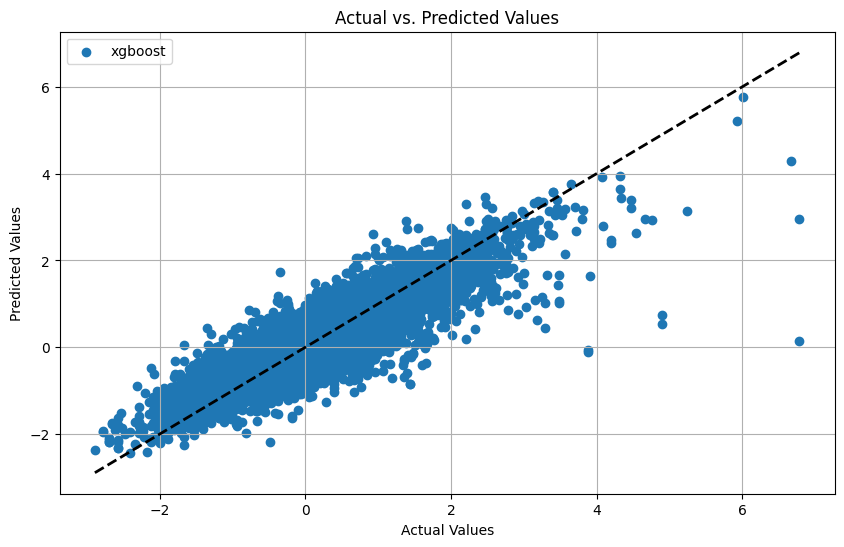

In [19]:
# We create a scatter plot to compare the actual vs. predicted values for each model.
# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, label=best_model_name)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Feature Importance

It is a post-training analysis technique used to understand which features (variables) have the most significant impact on the model's predictions. 

In [20]:
final_model = best_model_pipeline.named_steps['model']
final_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Feature Importance (from feature_importances_):
city_amsterdam: 0.2724888324737549
city_budapest: 0.154819056391716
city_athens: 0.14645476639270782
room_type_Entire home/apt: 0.081357441842556
city_rome: 0.05492369458079338
city_london: 0.040509313344955444
city_paris: 0.040344275534152985
space_index: 0.03673155978322029
room_type_Shared room: 0.03390098363161087
city_barcelona: 0.027509182691574097
attr_index_norm: 0.02576080709695816
city_lisbon: 0.02180640585720539
city_vienna: 0.011944394558668137
room_type_Private room: 0.011599007993936539
city_berlin: 0.0065750363282859325
biz: 0.006414094474166632
guest_satisfaction_overall: 0.00510398717597127
cleanliness_rating: 0.004697499796748161
metro_to_city_dist_ratio: 0.004512655083090067
rest_index_norm: 0.004464797209948301
multi: 0.002898097736760974
host_is_superhost: 0.0027226770762354136
day_type_weekdays: 0.002461374970152974
day_type_weekends: 0.0


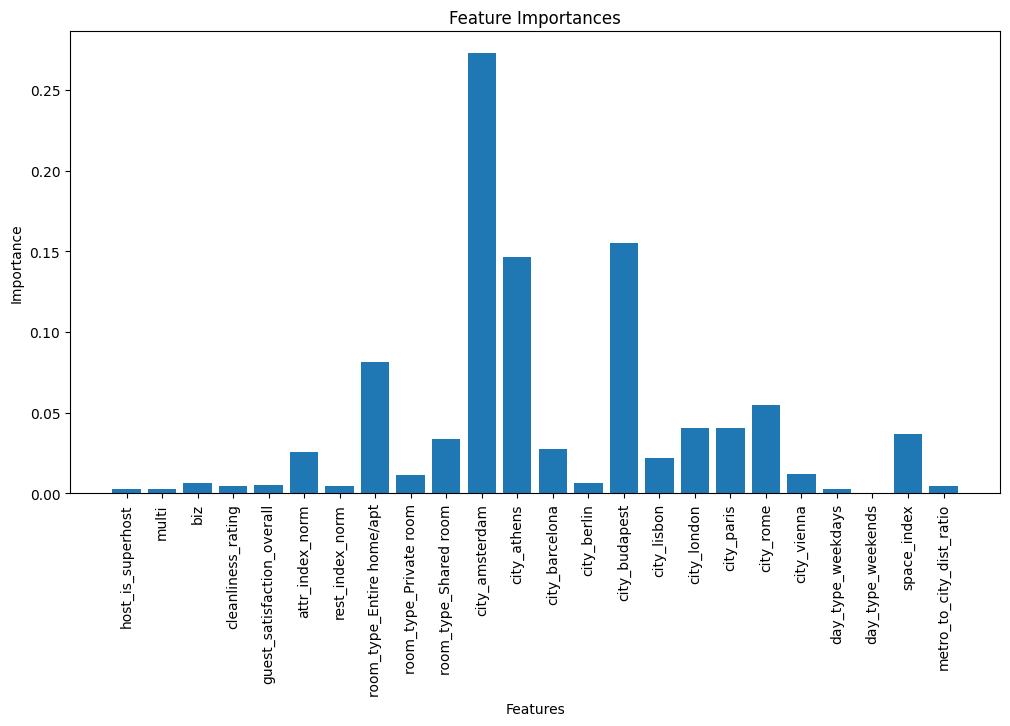

In [21]:
# Check for feature importances or coefficients
if hasattr(final_model, 'feature_importances_'):
    # For tree-based models
    feature_importances = final_model.feature_importances_
    feature_names = X_train.columns
    feature_importance_dict = dict(zip(feature_names, feature_importances))
    sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))
    print("Feature Importance (from feature_importances_):")
    for feature, importance in sorted_feature_importance.items():
        print(f"{feature}: {importance}")
    
    # Plotting the feature importances
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_importances)), feature_importances, align='center')
    plt.xticks(range(len(feature_importances)), feature_names, rotation=90)
    plt.title('Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

elif hasattr(final_model, 'coef_'):
    # For linear models
    feature_importances = final_model.coef_
    feature_names = X_train.columns
    feature_importance_dict = dict(zip(feature_names, feature_importances))
    sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: abs(item[1]), reverse=True))
    print("Feature Importance (from coef_):")
    for feature, importance in sorted_feature_importance.items():
        print(f"{feature}: {importance}")
    
    # Plotting the feature importances
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_importances)), feature_importances, align='center')
    plt.xticks(range(len(feature_importances)), feature_names, rotation=90)
    plt.title('Feature Coefficients')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.show()

else:
    print("Feature importance is not available for this model.")

we observe that the city based variables are highly influential to predict the listing price. As seen in the EDA, Amsterdam is highly expensive, which is also highlighted in its feature importance. This suggests a unique characteristic of the city - which may be modelled on the real life housing crisis and high cost of living in the Netherlands.

Typically, entire homes cost more than a room, which substantially affects the pricing model. The `attraction_index`, `restaurant_index` and `space_index` play a moderately significant role in influencing the model results. This is logically valid as in real life, the attractiveness of the location is a key factor while considering bookings for vacation.

## Residual Analysis

It helps to understand how well the model fits the data by examining the differences between the observed values and the predicted values (residuals). In a well-fitted linear regression model, residuals should have no discernible pattern when plotted against the predicted values. This is used as a diagnostic tool.

In [22]:
# Calculate residuals
residuals = y_test - test_predictions

Residual plot is a scatter plot which helps to check if residuals have any specific pattern. Ideally, it should be random (which it is, in the plot).

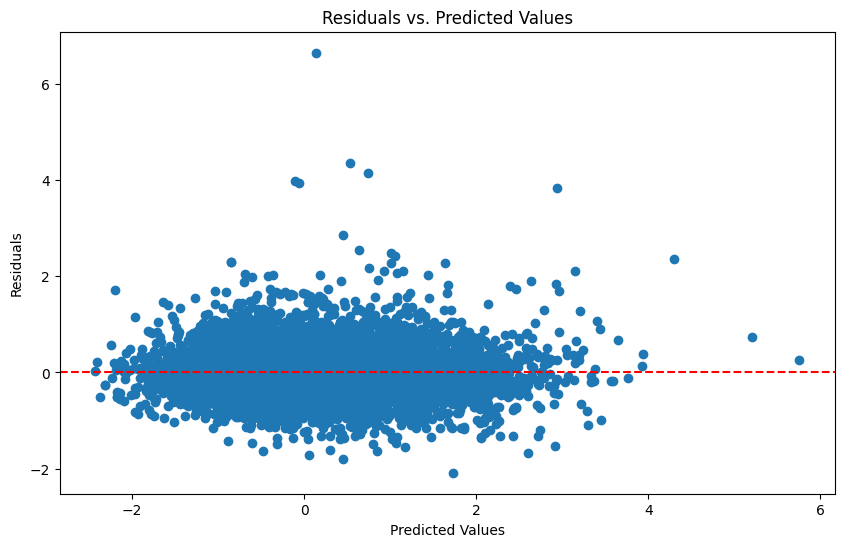

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(test_predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

Residual Distribution should ideally be approximately normally distributed. This is because the errors should be random (no pattern), and if so, they should obey the Central Limit Theorem.

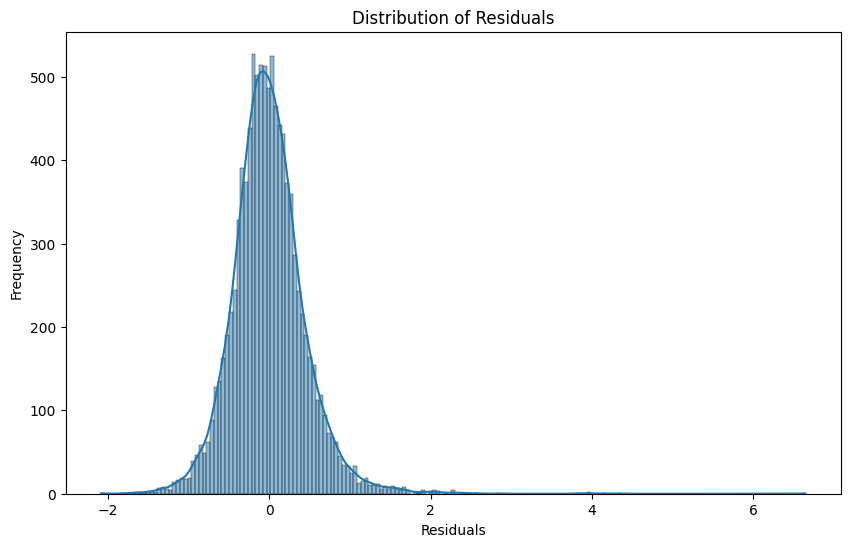

In [24]:
# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

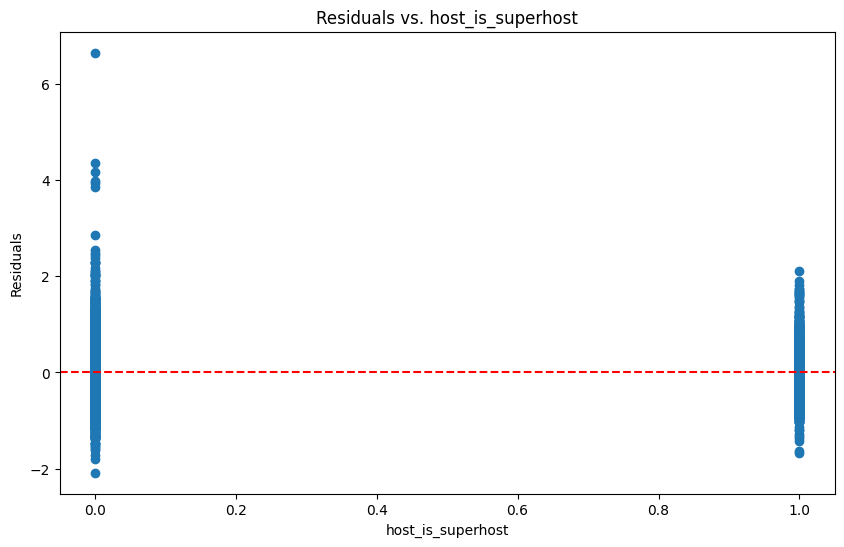

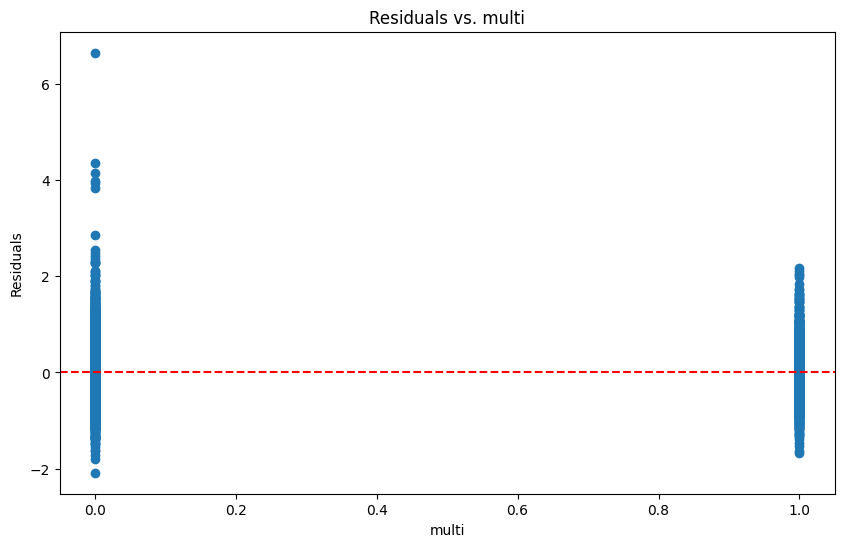

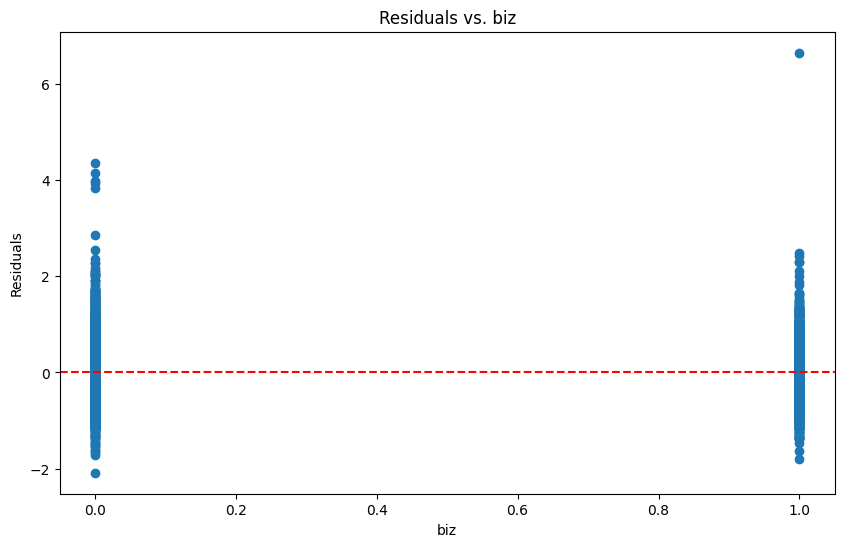

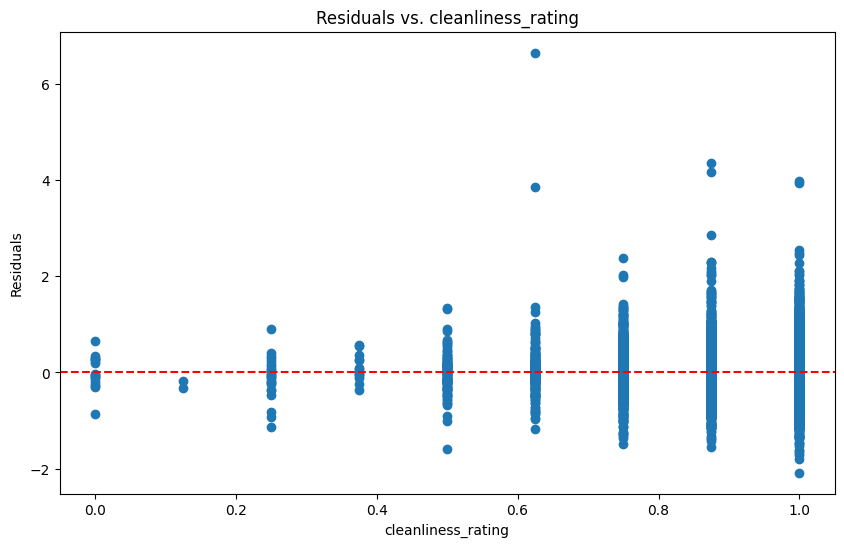

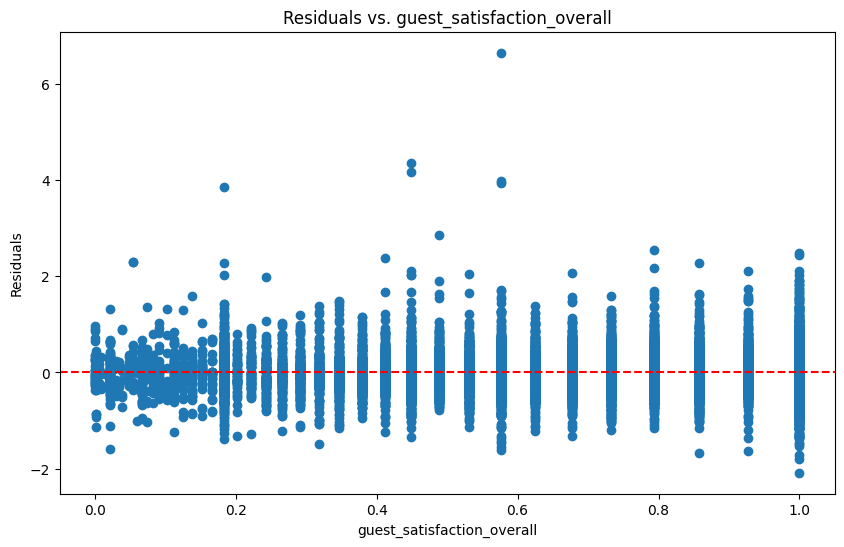

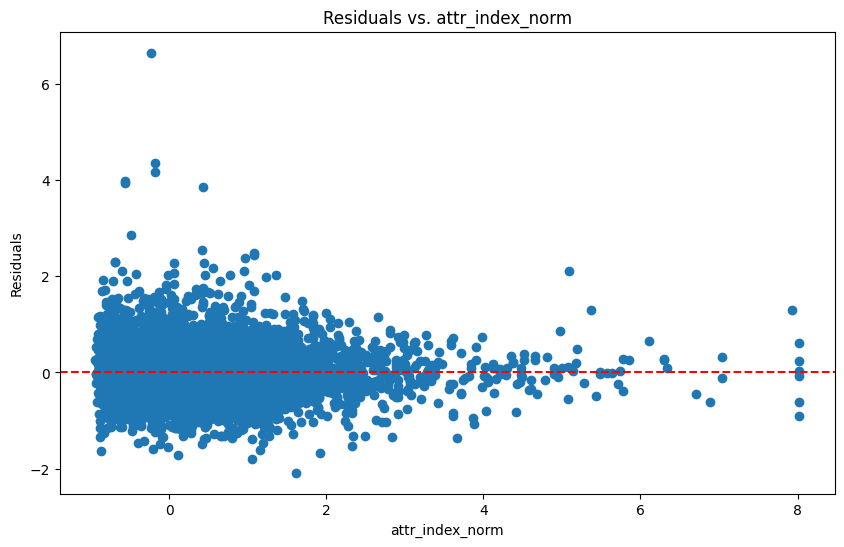

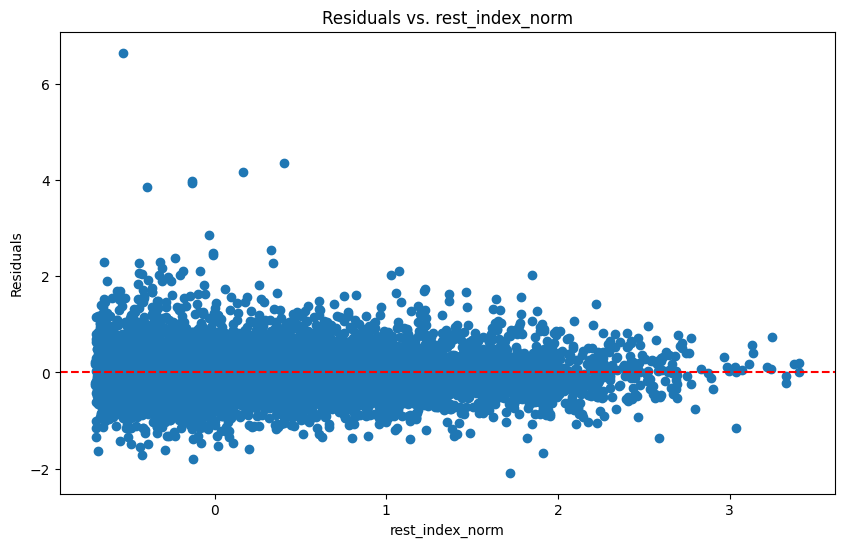

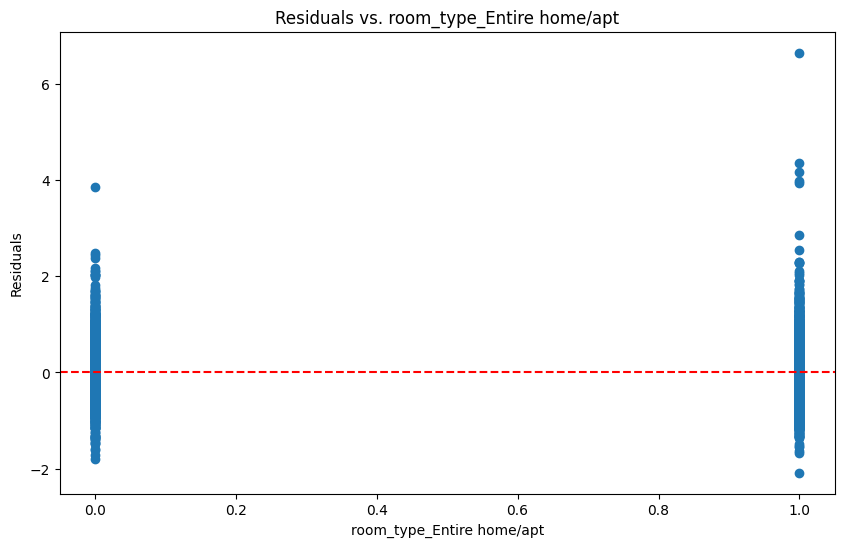

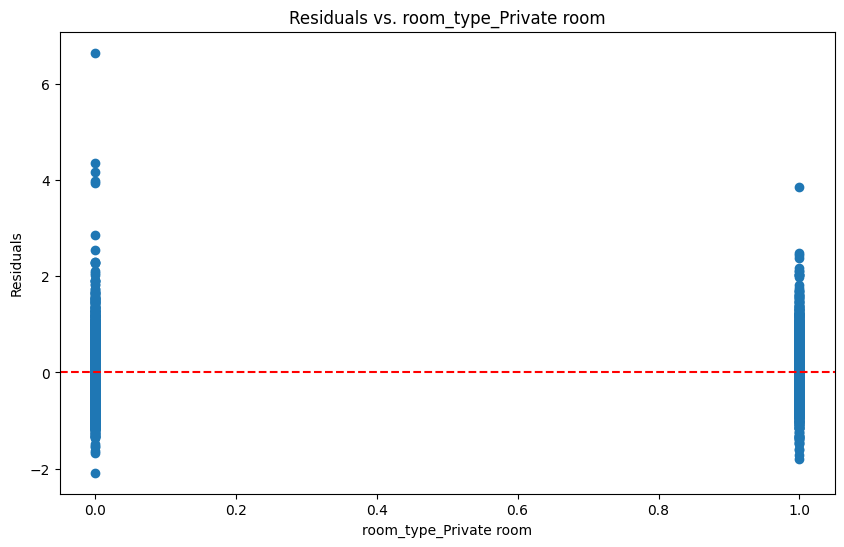

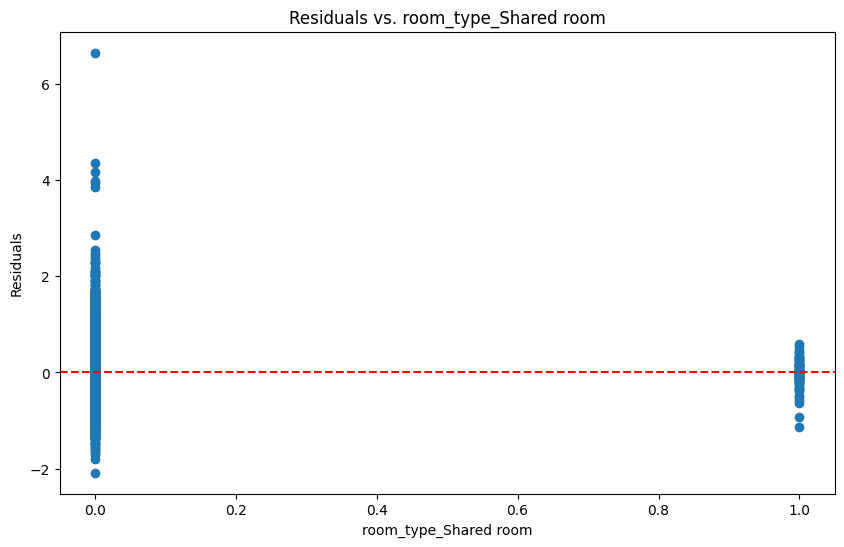

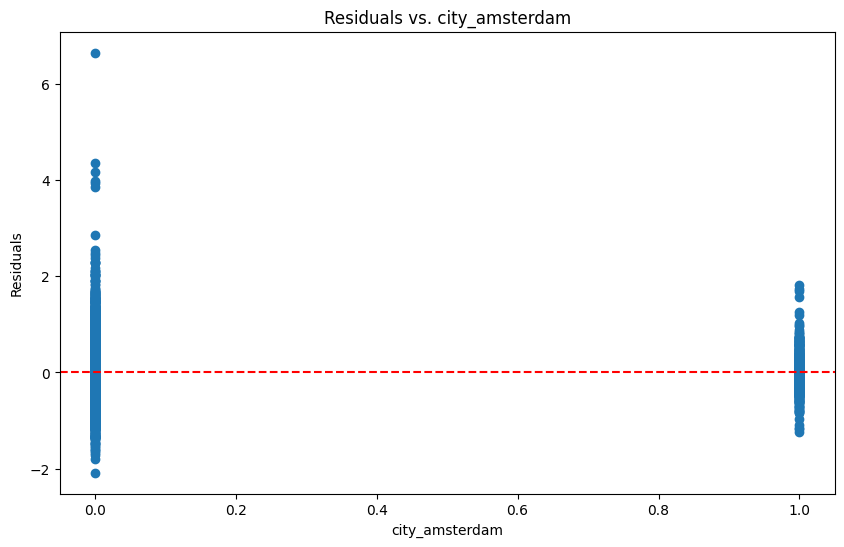

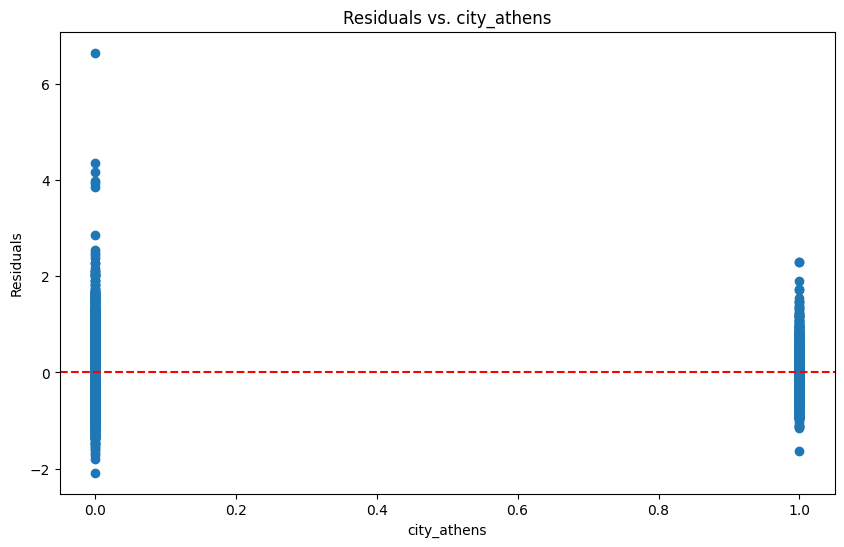

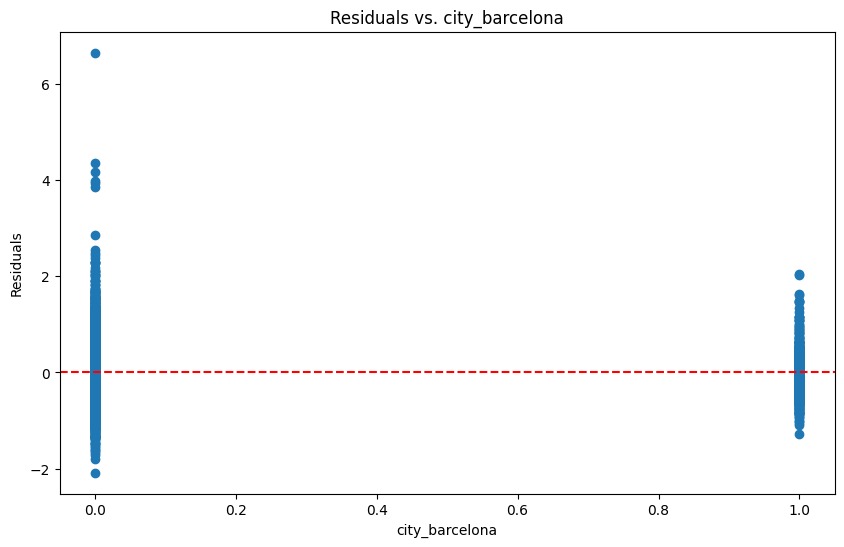

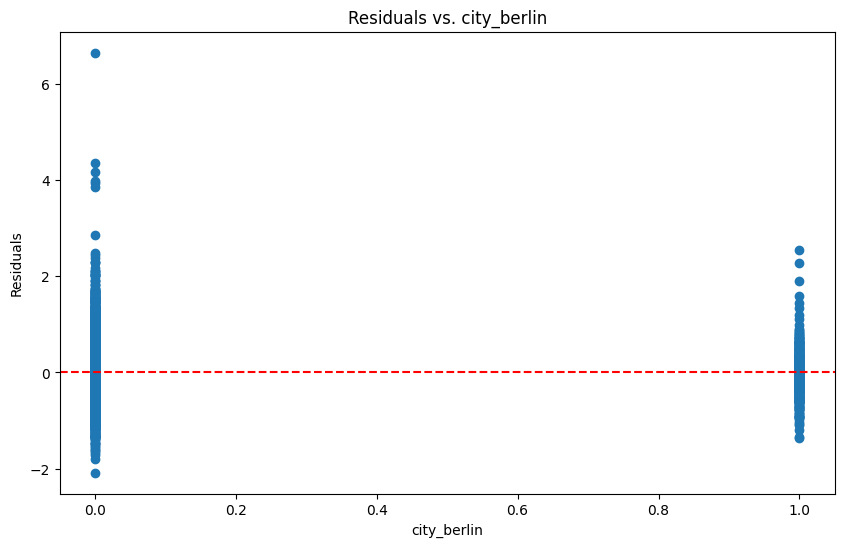

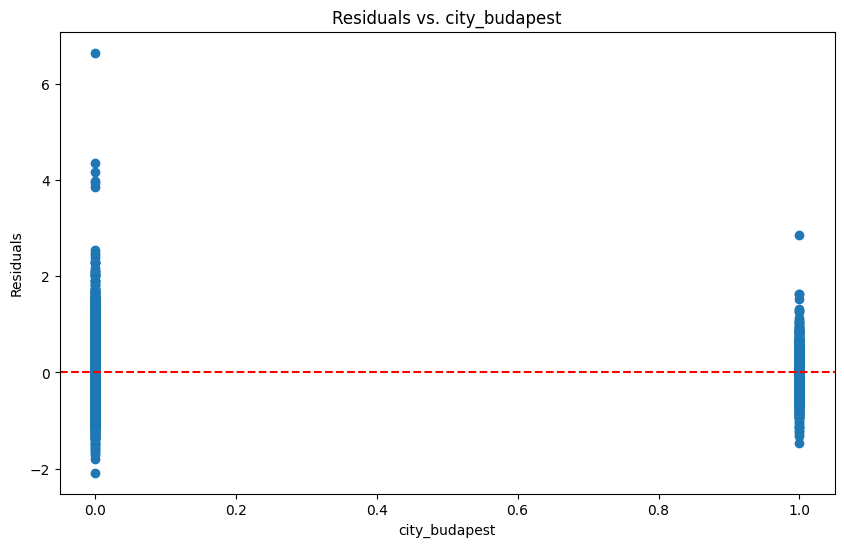

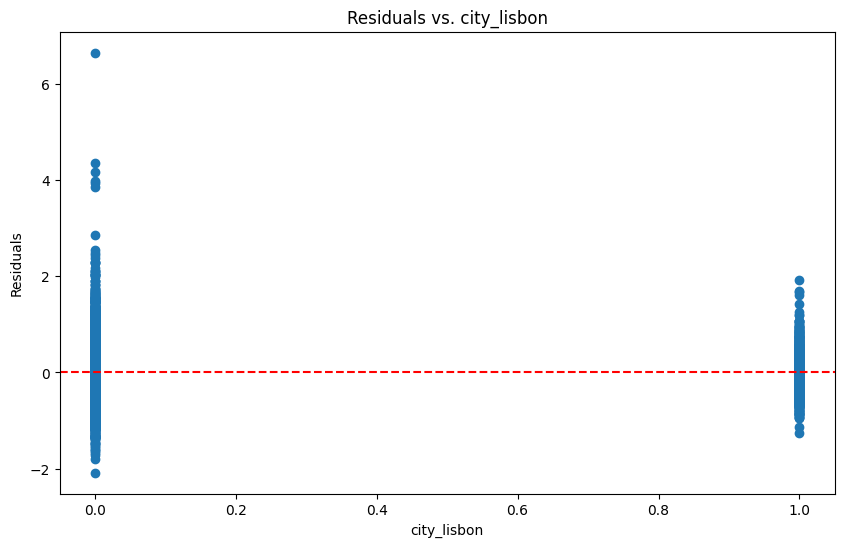

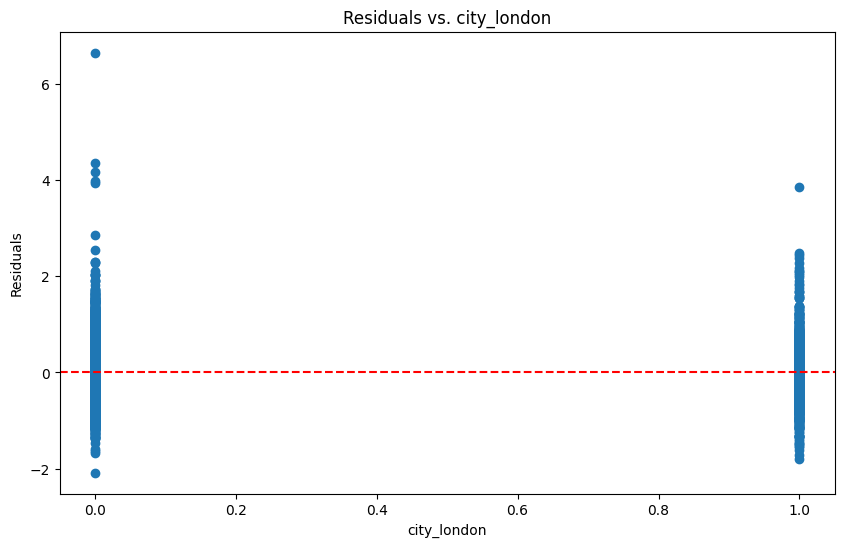

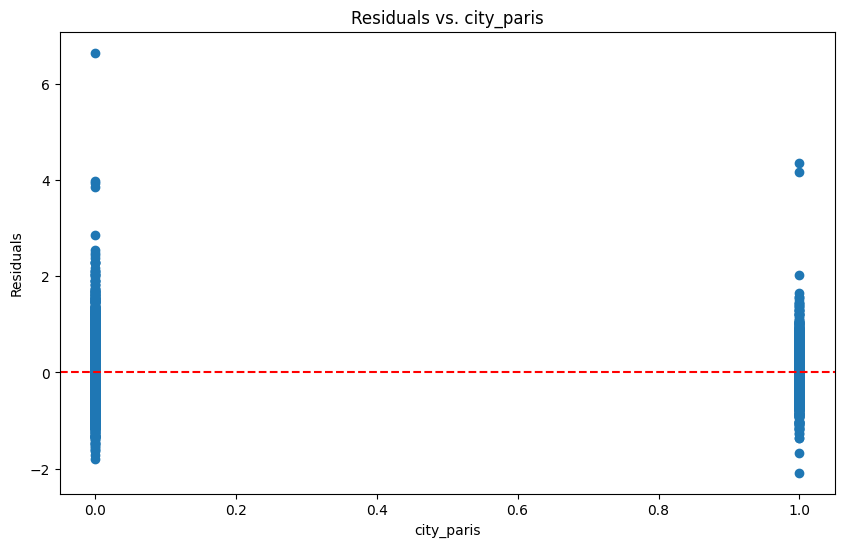

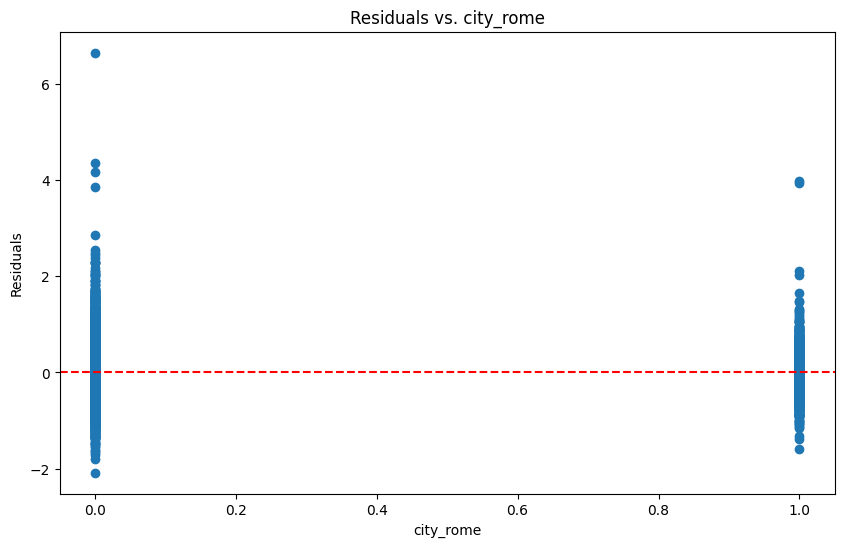

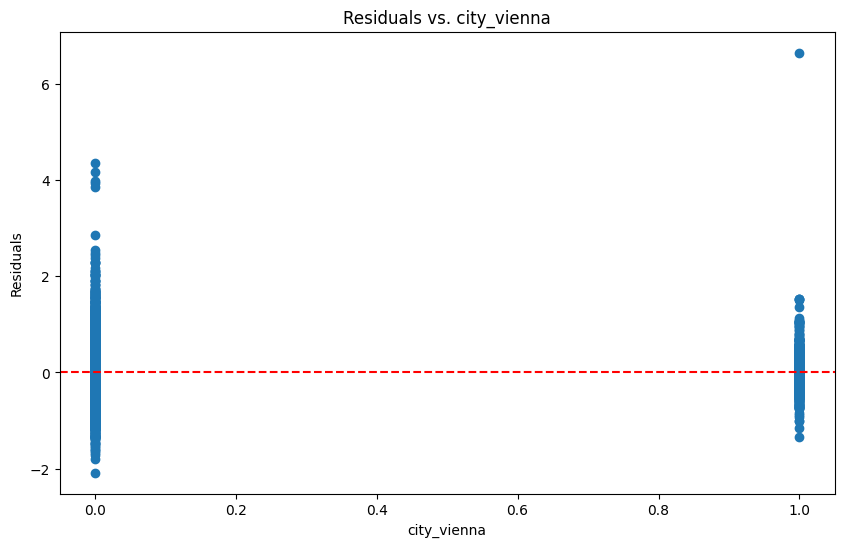

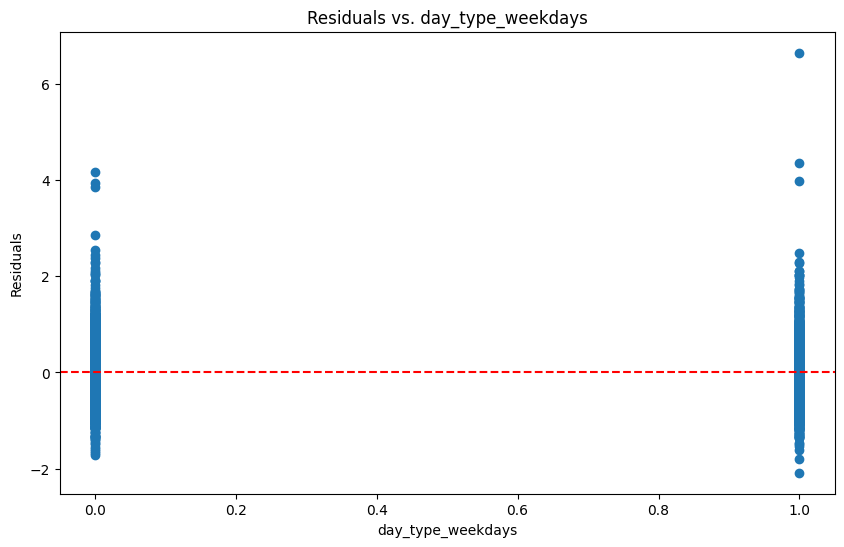

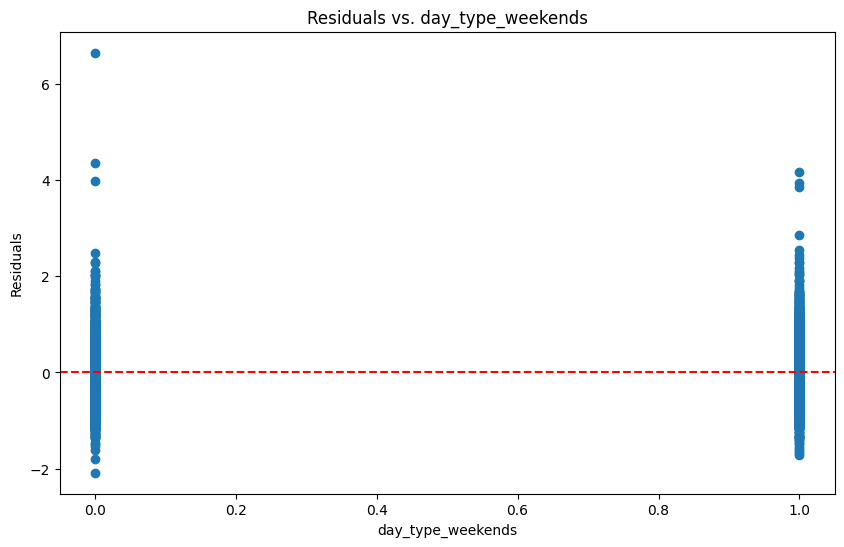

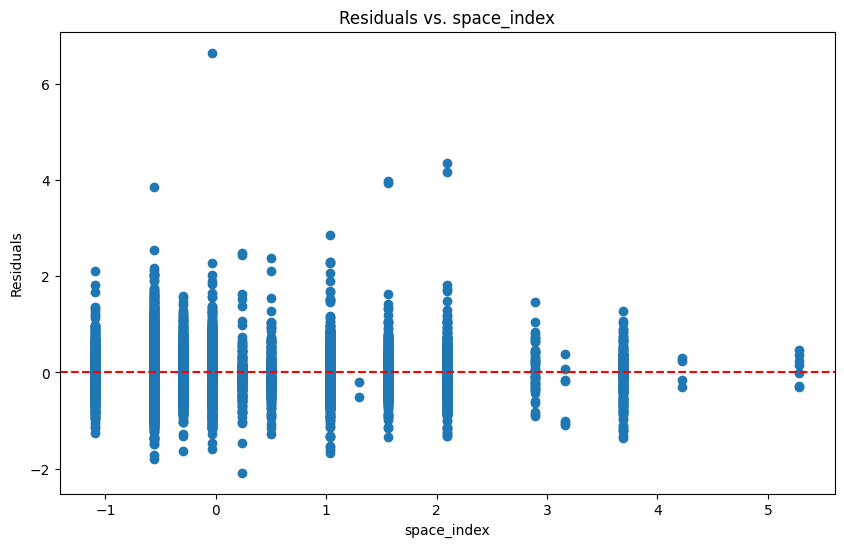

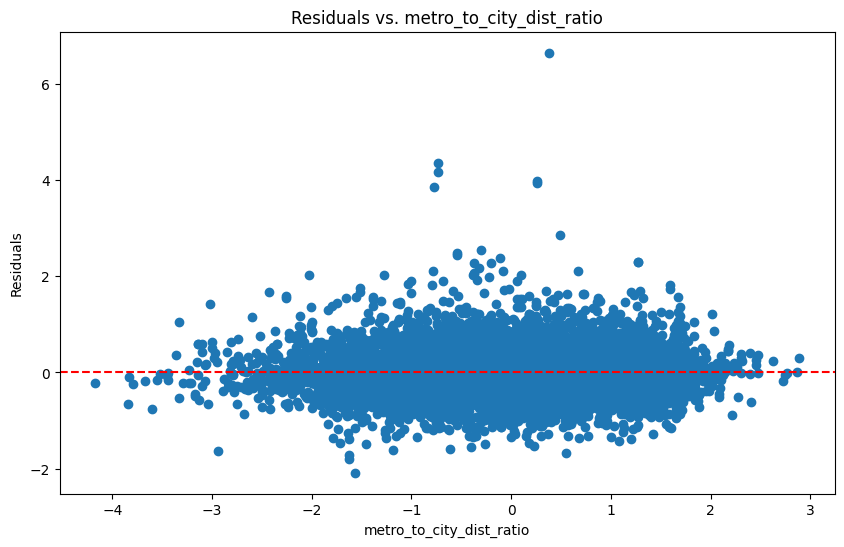

In [27]:
# Residuals vs. each predictor variable
for col in X_test.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test[col], residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residuals vs. {col}')
    plt.xlabel(col)
    plt.ylabel('Residuals')
    plt.show()

## Conclusion

This dataset provides valuable insights into the influence of social dynamics and geographical factors on global markets, which in turn guide the development of pricing strategies for maximizing profitability. In this project, we modelled the distribution of this data on the given factors across cities and vacation days (weekends, weekdays). The best algorithm to model this data is xgboost. Following a data first approach, we can continue to improve the data; by integrating it with other datasets to enrich our understanding. We can also then try out ensemble of modell, including simple neural networks to model the data better. For the sake of interpretability, we used certain baseline models to provide a comprehensive data understanding and predictions.